In [1]:
import sys
sys.path.insert(1, '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/')

from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
import logging
from scannotation import ASAPP
from data._dataloader import DataSet
from util import _topics


import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc

from data import _sim 
from scipy import stats
from sklearn.metrics import mean_squared_error as mse


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

dl = DataSet()
dl.config = args
dl.initialize_path()
dl.initialize_data()
dl.load_data()
print(dl.inpath)
print(dl.outpath)

/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/pbmc/pbmc
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/pbmc/pbmc


In [2]:
logging.basicConfig(filename=dl.outpath+'_model.log',
						format='%(asctime)s %(levelname)-8s %(message)s',
						level=logging.INFO,
						datefmt='%Y-%m-%d %H:%M:%S')

asap = ASAPP(adata=dl,tree_min_leaf=25,tree_max_depth=10, factorization='MVB',max_iter=10,n_pass=50)
asap.factorize()
asap.save_model()

/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/model/_dcpmf.py:61: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/model/_dcpmf.py:61: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)


In [3]:
fn = dl.outpath
df_d = pd.read_csv(fn+'_model_depth.csv.gz')
df_f = pd.read_csv(fn+'_model_freq.csv.gz')
df_beta = pd.read_csv(fn+'_model_beta.csv.gz')
df_theta = pd.read_csv(fn+'_model_theta.csv.gz')
df_theta = df_theta.rename(columns={'Unnamed: 0':'cell'})
df_beta = df_beta.rename(columns={'Unnamed: 0':'topic'})
df_trace= pd.read_csv(fn+'_model_bulk_trace.csv.gz')


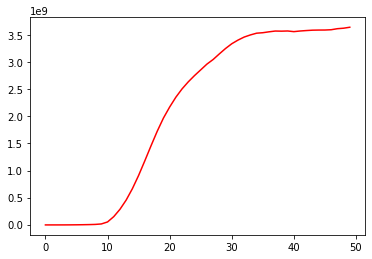

In [4]:

plt.plot(asap.model.bound,'r')


In [5]:
df_pl = pd.read_csv('/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/pbmc/pbmc_prior_label.csv.gz')
df_pl

,cell,label,umap1,umap2,cell_type
0,AAACATACAACCAC-1,0,8.927887,3.253341,CD4
1,AAACATTGAGCTAC-1,2,7.016333,10.311687,B
2,AAACATTGATCAGC-1,0,10.921963,4.996583,CD4
3,AAACCGTGCTTCCG-1,1,-1.403201,4.500485,CD14
4,AAACCGTGTATGCG-1,5,11.737618,-1.013121,NK
...,...,...,...,...,...
2690,TTTCGAACTCTCAT-1,1,0.464932,6.255583,CD14
2691,TTTCTACTGAGGCA-1,2,6.952725,10.245164,B
2692,TTTCTACTTCCTCG-1,2,5.122360,9.857081,B
2693,TTTGCATGAGAGGC-1,2,5.292380,11.635183,B


In [6]:
import umap
df_theta = pd.DataFrame(asap.model.Etheta)
df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows
df_umap['topic'] = [x for x in df_theta.iloc[:,1:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.0,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

# df_umap = pd.read_csv(sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id+'_sc_umap.csv')
# df_umap = df_umap.rename(columns={'Unnamed: 0':'cell','V1':'umap1','V2':'umap2'})
# df_umap['topic_sc'] = [x for x in df_sctheta.iloc[:,1:].idxmax(axis=1)]
# df_umap['topic_bulk'] = [x for x in df_btheta.iloc[:,1:].idxmax(axis=1)]

# df_umap

,cell,topic,umap1,umap2
0,AAACATACAACCAC-1,5,5.515431,4.675223
1,AAACATTGAGCTAC-1,6,1.271428,-9.332015
2,AAACATTGATCAGC-1,7,7.757611,3.824341
3,AAACCGTGCTTCCG-1,8,5.061442,13.040579
4,AAACCGTGTATGCG-1,7,12.295448,1.780796
...,...,...,...,...
2695,TTTCGAACTCTCAT-1,8,4.632963,13.101090
2696,TTTCTACTGAGGCA-1,5,6.342670,6.320048
2697,TTTCTACTTCCTCG-1,2,-0.517088,4.021026
2698,TTTGCATGAGAGGC-1,6,8.597106,21.162123


In [7]:
df_umap = pd.merge(df_umap,df_pl[['cell','cell_type']],on='cell',how='left')
df_umap = df_umap[~df_umap['cell_type'].isna()]
df_umap

,cell,topic,umap1,umap2,cell_type
0,AAACATACAACCAC-1,5,5.515431,4.675223,CD4
1,AAACATTGAGCTAC-1,6,1.271428,-9.332015,B
2,AAACATTGATCAGC-1,7,7.757611,3.824341,CD4
3,AAACCGTGCTTCCG-1,8,5.061442,13.040579,CD14
4,AAACCGTGTATGCG-1,7,12.295448,1.780796,NK
...,...,...,...,...,...
2695,TTTCGAACTCTCAT-1,8,4.632963,13.101090,CD14
2696,TTTCTACTGAGGCA-1,5,6.342670,6.320048,B
2697,TTTCTACTTCCTCG-1,2,-0.517088,4.021026,B
2698,TTTGCATGAGAGGC-1,6,8.597106,21.162123,B


In [8]:
df_umap.cell_type.value_counts()

CD4       1135
CD14       486
B          347
CD8        344
FCG        164
NK         161
Dend        36
Megak       13
others       9
Name: cell_type, dtype: int64

Text(0.5, 1.0, 'dcpmf')

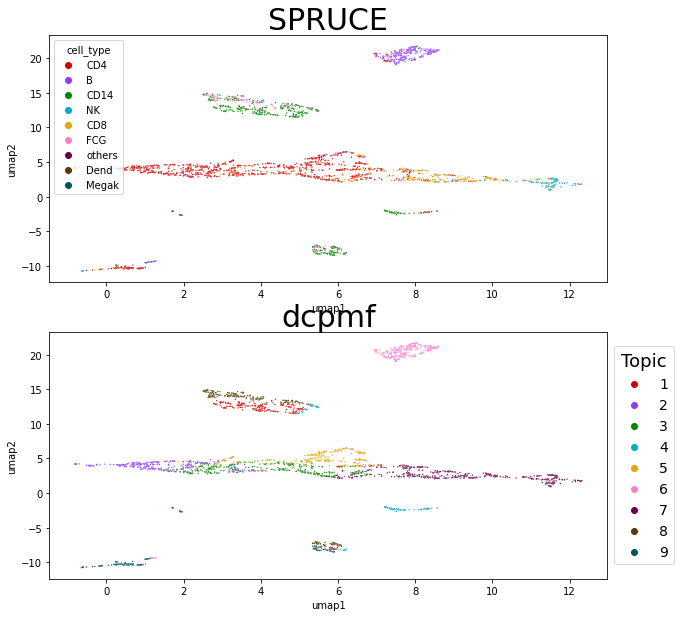

In [11]:


figure,axis = plt.subplots(2,1)
plt.rcParams["figure.figsize"] = (10,10)


cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type',s=2,palette=cp,legend=True,ax=axis[0])
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("SPRUCE",fontsize=30)


cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic',s=2,palette=cp,legend=True,ax=axis[1])
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("dcpmf",fontsize=30)



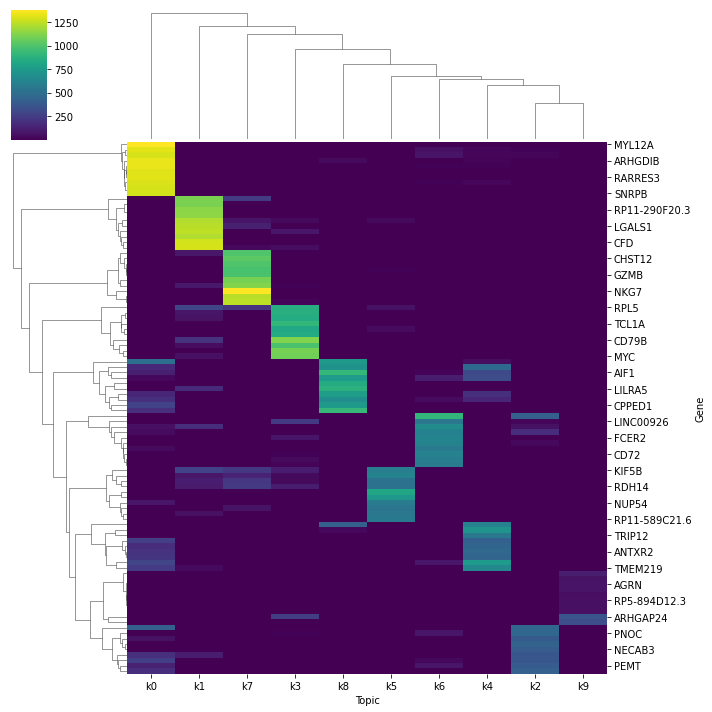

In [10]:
df_top = _topics.get_topic_top_genes(df_beta.iloc[:,1:],top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')